# ScanPy Analysis

Here we will use the infected cells

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc

In [9]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


In [31]:
# Transpose -- the CSV
adata = sc.read_csv('Injected_cells_batch2.tsv',                    
                    delimiter='\t').T

In [32]:
adata

AnnData object with n_obs × n_vars = 1536 × 34205

In [33]:
adata.obs_names

Index(['aMIDMSOE14RP13_1', 'aMIDMSOE14RP13_2', 'aMIDMSOE14RP13_3',
       'aMIDMSOE14RP13_4', 'aMIDMSOE14RP13_5', 'aMIDMSOE14RP13_6',
       'aMIDMSOE14RP13_7', 'aMIDMSOE14RP13_8', 'aMIDMSOE14RP13_9',
       'aMIDMSOE14RP13_10',
       ...
       'aMIEPZE14RP4_183', 'aMIEPZE14RP4_184', 'aMIEPZE14RP4_185',
       'aMIEPZE14RP4_186', 'aMIEPZE14RP4_187', 'aMIEPZE14RP4_188',
       'aMIEPZE14RP4_189', 'aMIEPZE14RP4_190', 'aMIEPZE14RP4_191',
       'aMIEPZE14RP4_192'],
      dtype='object', length=1536)

In [34]:
adata.var_names

Index(['0610007P14Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik',
       '0610009O20Rik', '0610010F05Rik', '0610010K14Rik', '0610011F06Rik',
       '0610012D04Rik', '0610012G03Rik',
       ...
       'Zw10', 'Zwilch', 'Zwint', 'Zxdb', 'Zxdc', 'Zyg11a', 'Zyg11b', 'Zyx',
       'Zzef1', 'Zzz3'],
      dtype='object', length=34205)

In [35]:
adata.var_names_make_unique()

In [36]:
adata

AnnData object with n_obs × n_vars = 1536 × 34205

### Preprocessing

normalizing counts per cell
    finished (0:00:00)


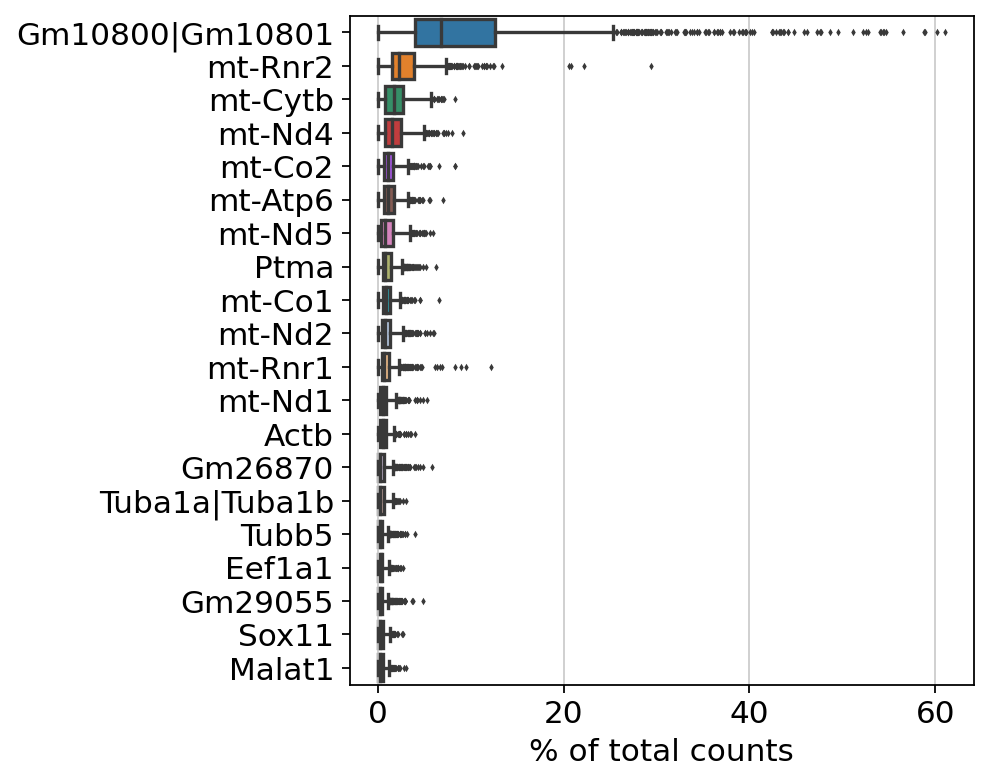

In [37]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [38]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 552 cells that have less than 200 genes expressed


/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 18249 genes that are detected in less than 3 cells


In [41]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

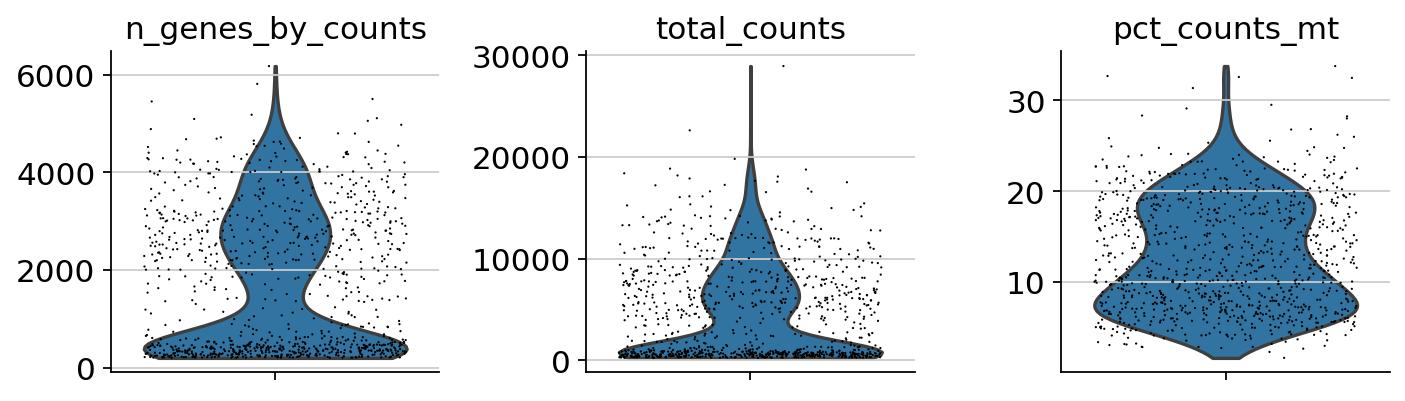

In [42]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Wow, many of these cells have expression dominated by mitochondrial genes...

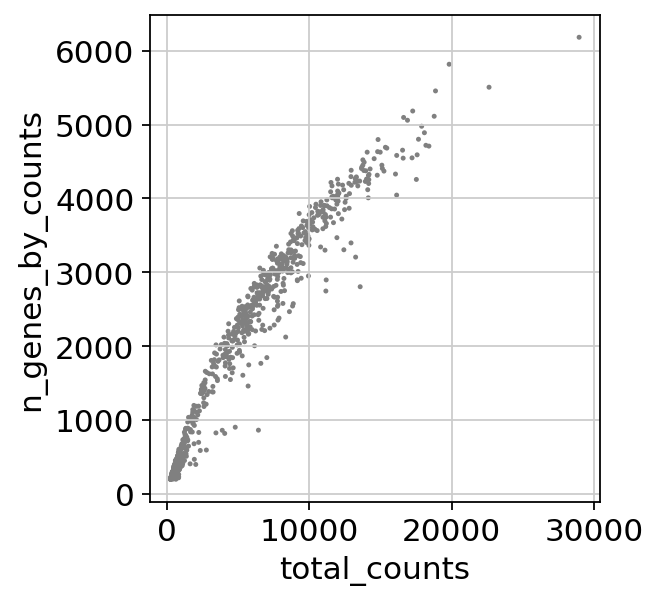

In [55]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', size=20)

This looks normal

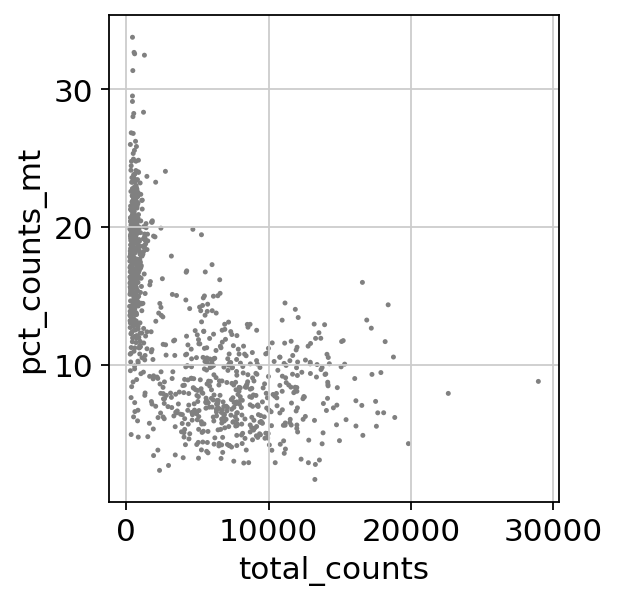

984

In [85]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', size=20)
len(adata.obs)

Many of the cells which have mitochondrial contamination have very low counts. We could likely get rid of them just by filtering out cells with total counts less than 1500 and we can remove the two outlier cells > 20000.

In [90]:
adata2 = adata[adata.obs.total_counts > 1500, :]
adata2 = adata2[adata2.obs.total_counts < 20000, :]
len(adata2.obs)

/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


533

We lose 451 cells, just from removing cells with libsizes < 1500, all of which were highly MT-contaminated cells.... Wow. Maybe we should do an analysis later which keeps them in.

For now, let's kick them out and focus on the good quality cells

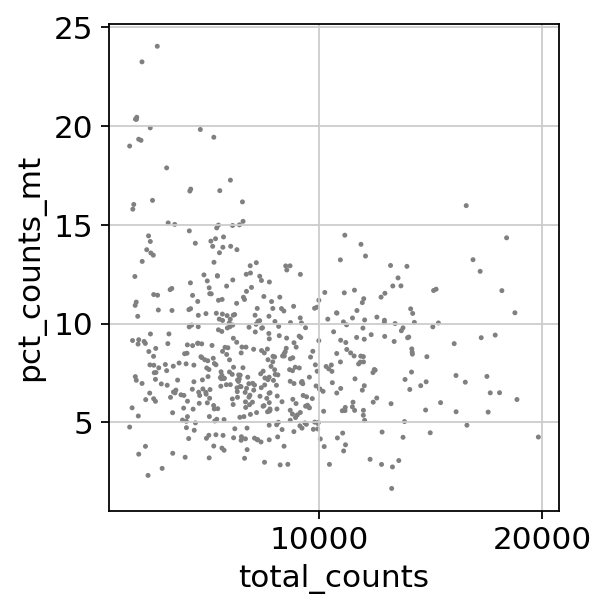

In [87]:
sc.pl.scatter(adata2, x='total_counts', y='pct_counts_mt', size=20)

looks better - now let's remove the really MT expressive cells (above 15%)

In [91]:
adata2 = adata2[adata2.obs.pct_counts_mt < 15, :]
len(adata2.obs)

/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


509

24 cells removed, that's fine.

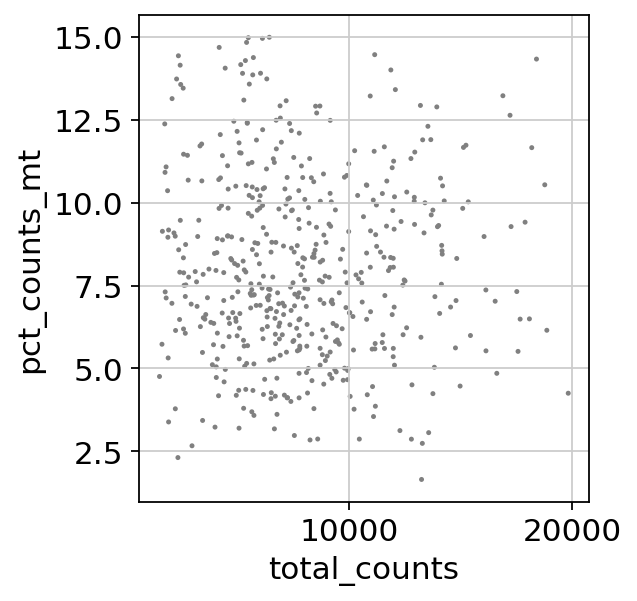

In [92]:
sc.pl.scatter(adata2, x='total_counts', y='pct_counts_mt', size=20)

In [93]:
adata = adata2

Better. We can work with this.

In [94]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [95]:
adata

AnnData object with n_obs × n_vars = 509 × 15956
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [96]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


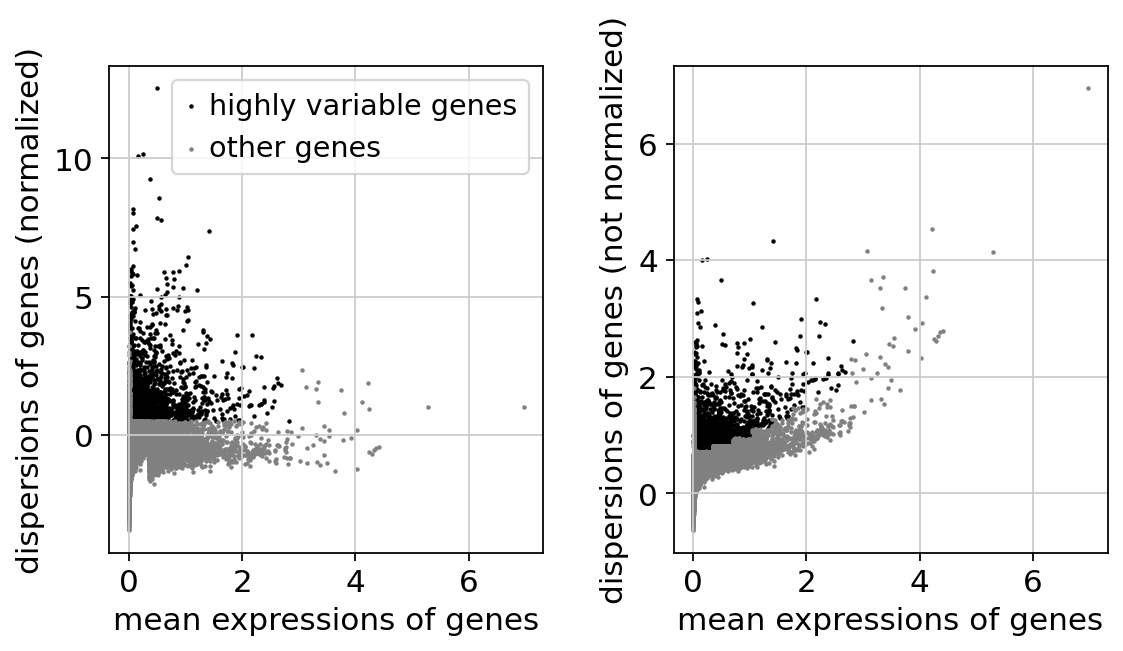

In [97]:
sc.pl.highly_variable_genes(adata)

In [98]:
adata.raw = adata

In [103]:
sum(adata.var.highly_variable)

3392

We reduce the number of genes from 15,956 to 3,392 -- and then we regress the effects of lib size and MT genes.

In [104]:
adata = adata[:, adata.var.highly_variable]

/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [105]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:05)


In [106]:
sc.pp.scale(adata, max_value=10)

## PCA

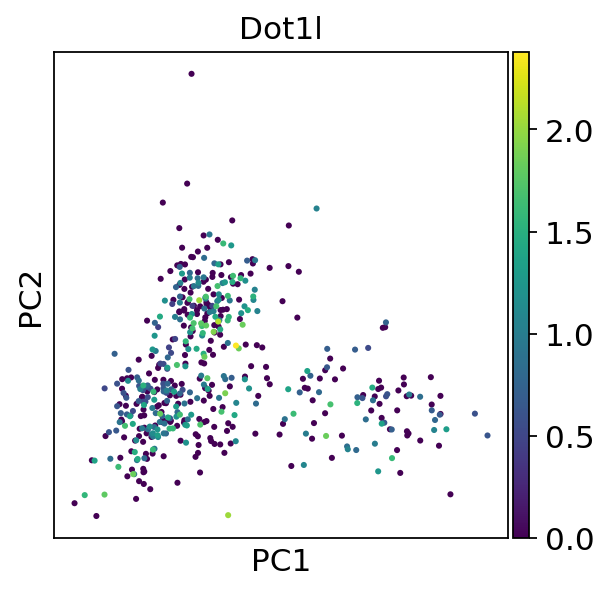

In [110]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color="Dot1l", size=30)

We see some seperation of the data in PC1 and PC2, and expression of Dot1l appears to be expressed pretty much everywhere. Unknown if this is good or not.

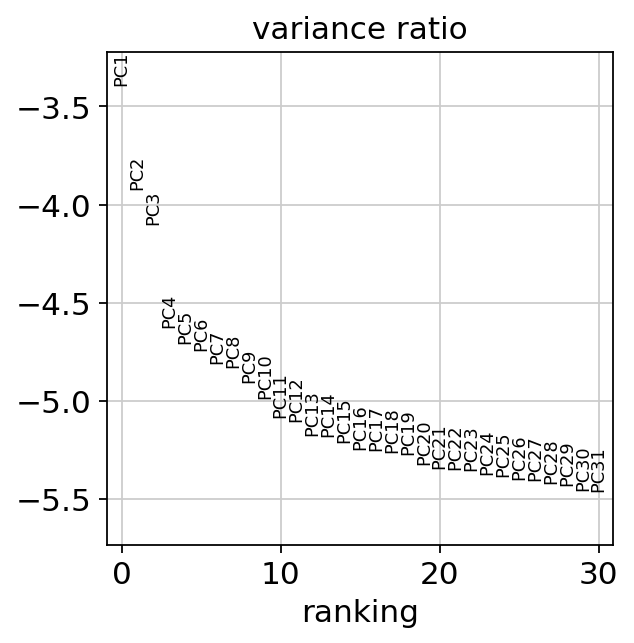

In [111]:
sc.pl.pca_variance_ratio(adata, log=True)

In [112]:
adata.write("files/3_paga/1_normalfilt.h5ad")

## Perform Clustering and UMAP

In [26]:
import numpy as np
import pandas as pd
import scanpy as sc
adata = sc.read("files/3_paga/1_normalfilt.h5ad")

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


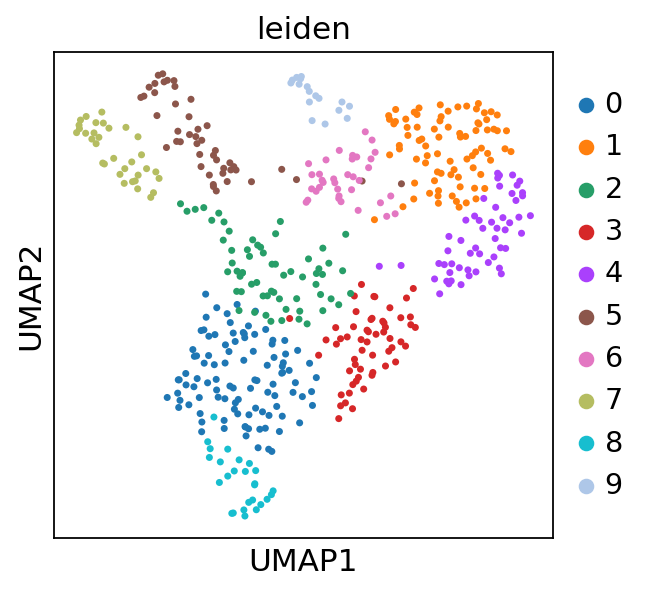

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, size=40, color="leiden")

Let's see if we can identify clusters based on Bismark's marker genes

From Slide 4:


| Names | Gene List |
|-------|-----------|
| Endothelial | Hes1 |
| NeuronsI | Tubb3, Elavl3, Dpysl3 |
| Transit cells | Nr2f1, Fgfr3, Hk2 |
| NeuronsII | Bxl11b, Tbr1, Tubb3, Elavl3, Dpysl3, Neurod6 |
| Intermedial Progenitors | Insm1, Eomes, Neurog2, Fezf2 |
| Apical Progenitors | Sox2, Fabp7, Ttyh1, Ptprz1, Sox9, Hes5 |

or just look at the image:

![Seurat Genes](files/3_paga/bismark.slide4.png)


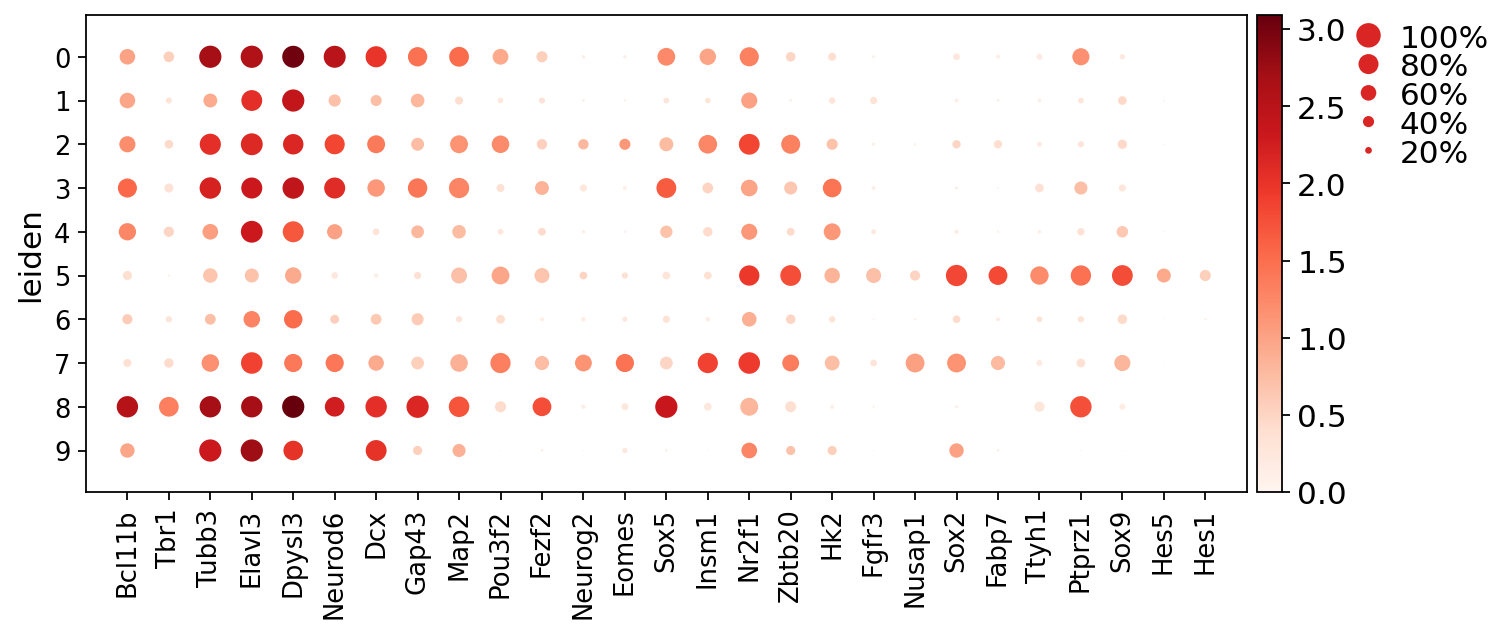

In [28]:
bismark_genes = ("Bcl11b", "Tbr1", "Tubb3", "Elavl3", "Dpysl3", 
                 "Neurod6", "Dcx", "Gap43", "Map2", "Pou3f2", "Fezf2",
                 "Neurog2", "Eomes", "Sox5", "Insm1", "Nr2f1", "Zbtb20",
                 "Hk2", "Fgfr3", "Nusap1", "Sox2", "Fabp7", "Ttyh1", "Ptprz1",
                 "Sox9", "Hes5", "Hes1")
sc.pl.dotplot(adata, bismark_genes, groupby='leiden');

| Cluster | Guessed Label | 
|---|---|
| 5 | Apical Progenitors |
| 0, 8 | Neurons |
| 1 | |


I am not sure if we can easily recuperate the same clusters. Hmm.

Another way to explore these kind of datasets is to use CellxGene, so I will just save our current object and load this into Galaxy

In [4]:
adata.write("files/3_paga/1_normalfilt.clustered.h5ad")

| Cluster | Most DE Genes (in descending order) | Okay |
|-----|--|--|
| 0 | 9130024F11Rik, Satb2, Stmn2, Ttc28, Clmp, Zfp462, Gpm6a | |
| 1 | 1810026B05Rik ("Chd2"), Odc1, Eif1, Pcbp1, Emd, Dusp8, Mn1   | Germ Cells |
| 2 | Elavl4, Rnd2, Trim2, Sstr2, Eomes | |
| 3 | Mapt, Neurod2, Pgk1, Cntn2, Sox5, Higd1a, Pfkfb3 | |
| 4 | Slc7a5, 2410006H16Rik, Hspa5, Ddit4, Bsg | |
| 5 | Ddah1, Vim, Mt1, Sox2, Sox9, Mfge8, Pea15a, Ptn, Dbi | |
| 6 | Gm37158, Gm37954, Gm17555, Gm21750, Gm37746, Gm42519, Gm17615, A430073D23Rik, Gm37324 | |
| 7 | Top2a, Mki67, Cdk1, Ccna2, Ncapd2, Rrm2 | |
| 8 | Opcml, Cdh13, Tox, Nin, Hivep2, Camk2b | |
| 9 | Meg3, Maf | Neurons |

In [32]:
cellx_genes = list(set(("9130024F11Rik", "Satb2", "Stmn2", "Ttc28", "Clmp", "Zfp462", "Gpm6a",
                "1810026B05Rik", "Odc1", "Eif1", "Pcbp1", "Emd", "Dusp8", "Mn1",
               "Elavl4", "Rnd2", "Trim2", "Sstr2", "Eomes",
               "Mapt", "Neurod2", "Pgk1", "Cntn2", "Sox5", "Higd1a", "Pfkfb3",
               "Slc7a5", "2410006H16Rik", "Hspa5", "Ddit4", "Bsg",
               "Ddah1", "Vim", "Mt1", "Sox2", "Sox9", "Mfge8", "Pea15a", "Ptn", "Dbi",
               "Gm37158", "Gm37954", "Gm17555", "Gm21750", "Gm37746", "Gm42519", "Gm17615", "A430073D23Rik", "Gm37324",
               "Top2a", "Mki67", "Cdk1", "Ccna2", "Ncapd2", "Rrm2",
               "Opcml", "Cdh13", "Tox", "Nin", "Hivep2", "Camk2b",
               "Meg3", "Maf")))

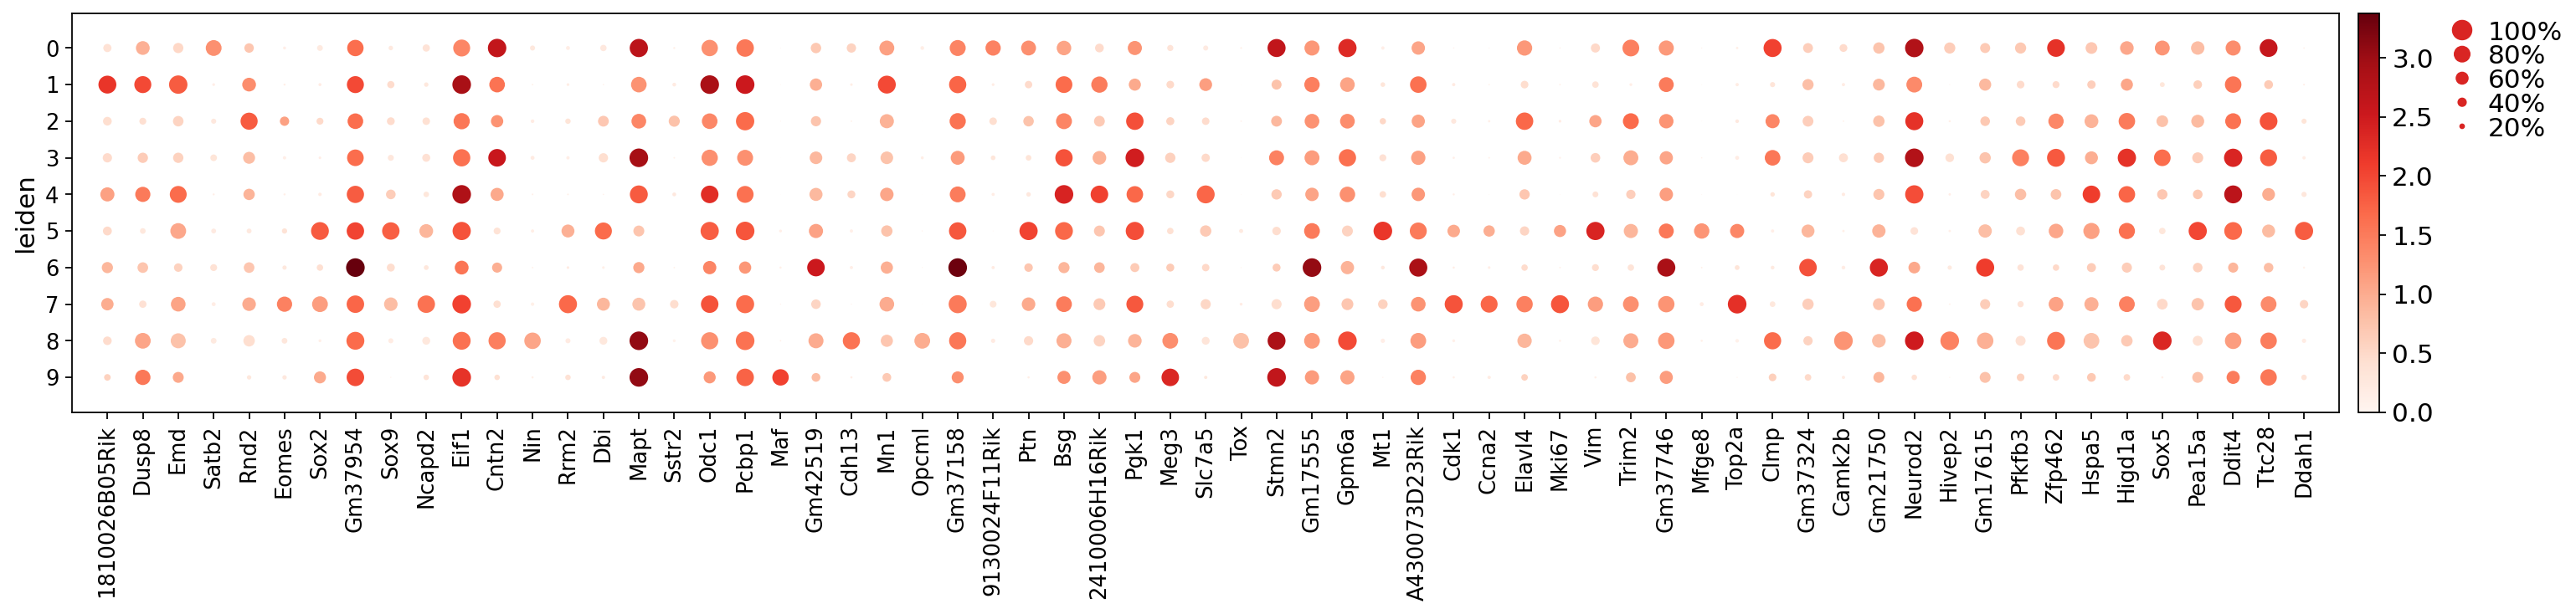

In [33]:
sc.pl.dotplot(adata, cellx_genes, groupby='leiden');

this is a mess. Let's use the official methods

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:06)


/home/tetris/repos/_work/_scrna/scRNA_2020_appiah/appiahenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


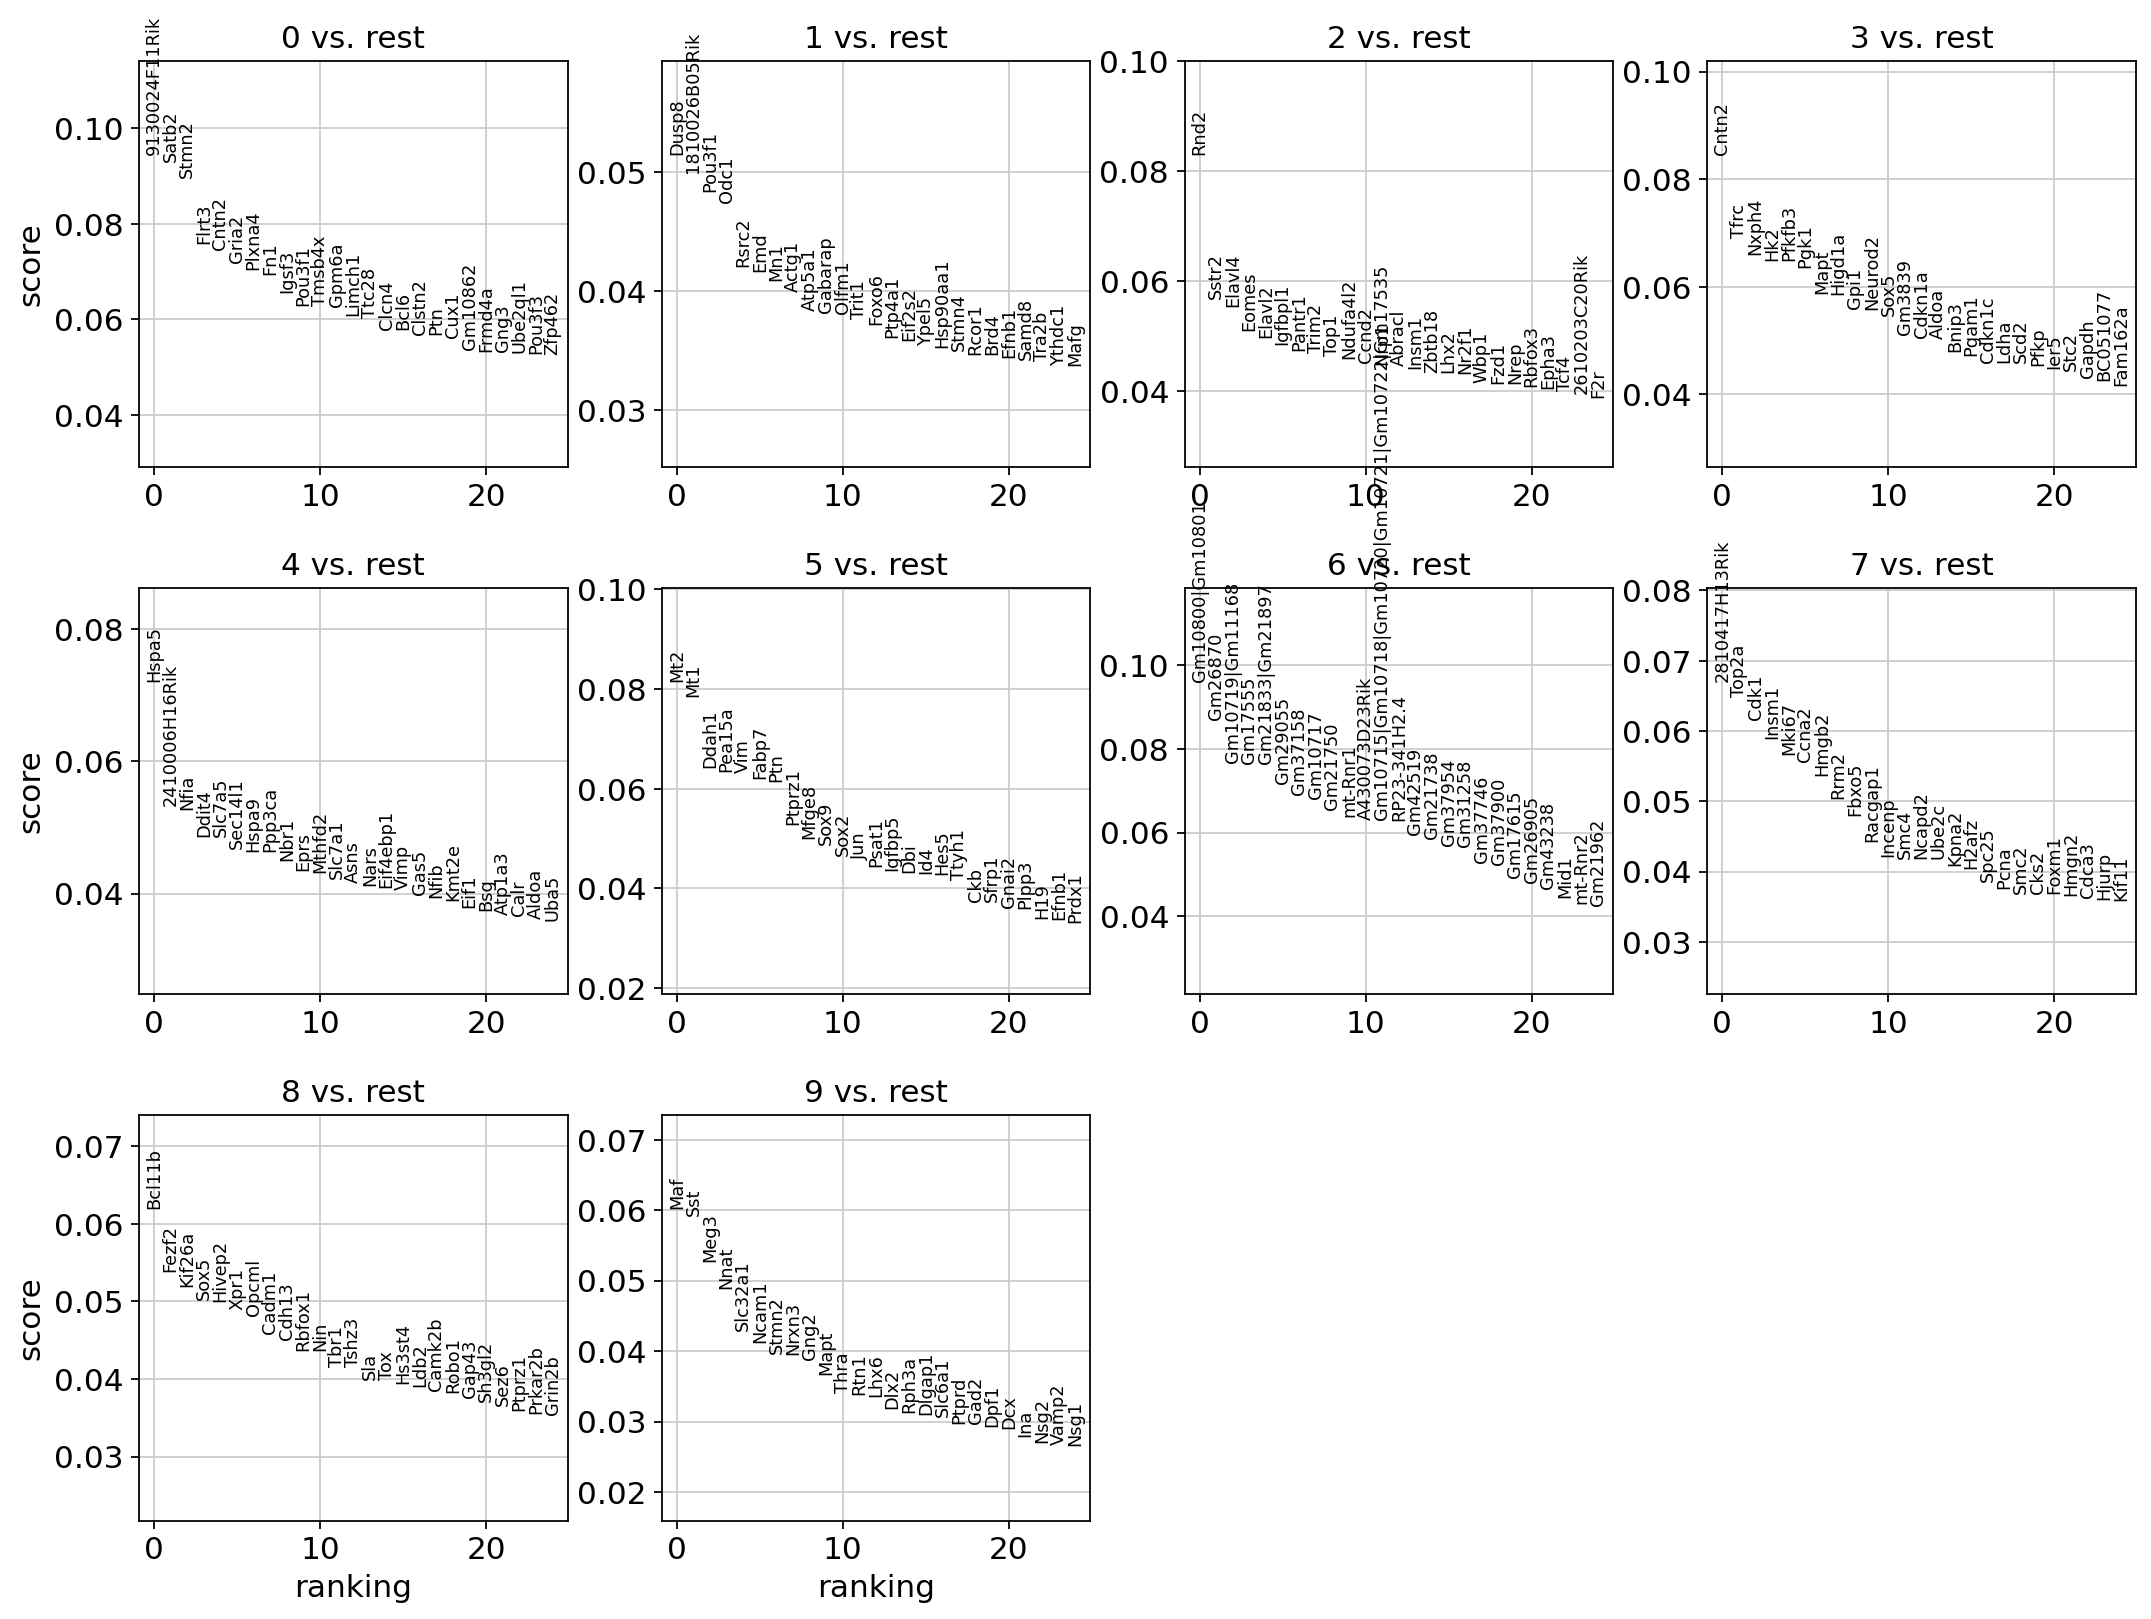

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Not entirely sure how to label these clusters, but let us attempt a trajectory inference and see if we can get better clarity from the cell ordering.

# Trajectory Inference

In [10]:
sc.tl.paga(adata, groups='leiden')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


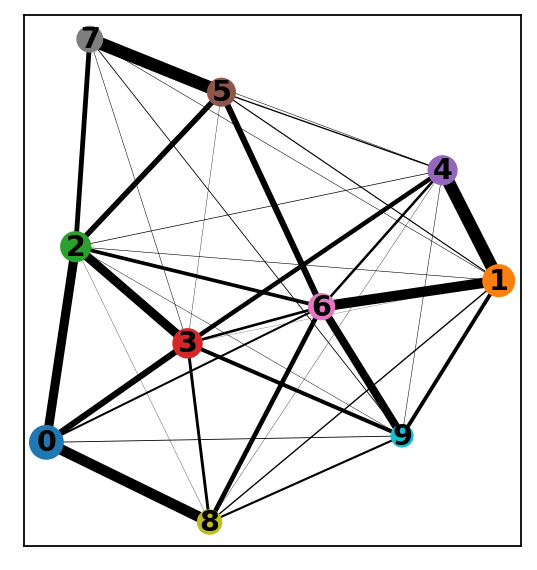

In [12]:
sc.pl.paga(adata, color='leiden')

### Denoising (not useful)

Let's try denoising the graph first, retry this step

In [13]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9758259  0.96644926 0.95460725 0.9407082  0.9195653
     0.9113767  0.8923452  0.8756687  0.873535   0.85829526 0.8415554
     0.8077726  0.79957783 0.7962844 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:00)


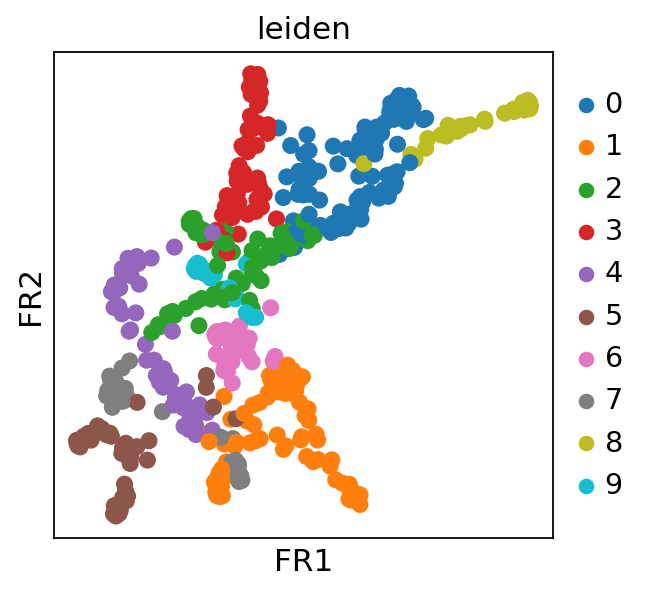

In [14]:
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='leiden')

In [19]:
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


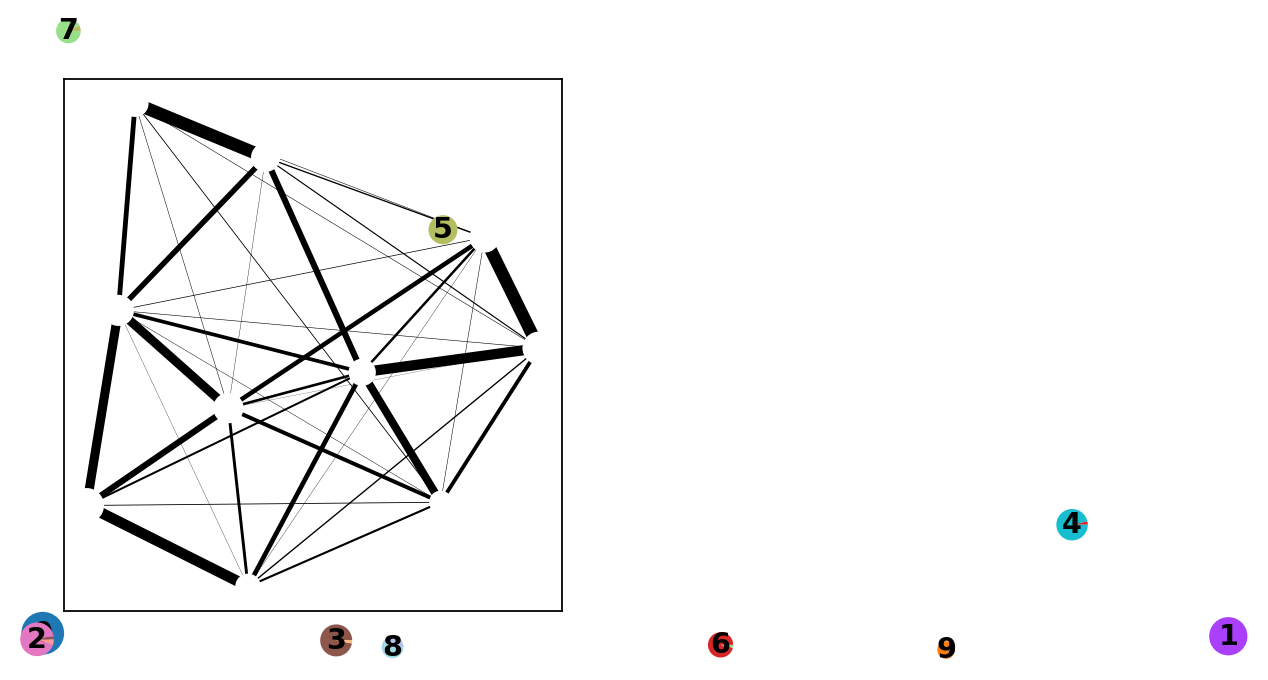

In [21]:
sc.pl.paga(adata, color='louvain')

the denoising really did not help

# Thoughts

I cannot replicate the same analysis that Bismark has, though that might be more due to the fact that I only have the Injected cells only.

One thing we can try is to take the existing Seurat object that Bismark has and to run Paga on it, since Paga here really does not appear to elucidate much.